# Brewing Logistic Regression then Going Deeper

While Caffe is made for deep networks it can likewise represent "shallow" models like logistic regression for classification. We'll do simple logistic regression on synthetic data that we'll generate and save to HDF5 to feed vectors to Caffe. Once that model is done, we'll add layers to improve accuracy. That's what Caffe is about: **define a model, experiment, and then deploy.**

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.chdir('..')
# 多运行几次这部分就凌乱了，所以我直接写死了。
CAFFE_ROOT = "/home/tzx/dev/caffe-rc3/"
print CAFFE_ROOT
os.chdir(CAFFE_ROOT)
print os.path.realpath(os.getcwd())

import sys
sys.path.insert(0, CAFFE_ROOT + 'python')
import caffe


import os
import h5py
import shutil
import tempfile

import sklearn
import sklearn.datasets
import sklearn.linear_model

import pandas as pd



/home/tzx/dev/caffe-rc3/
/home/tzx/dev/caffe-rc3


Synthesize a dataset of 10,000 4-vectors for binary clas e features.

shape of X:  (10000, 4)
shape of y:  (10000,)


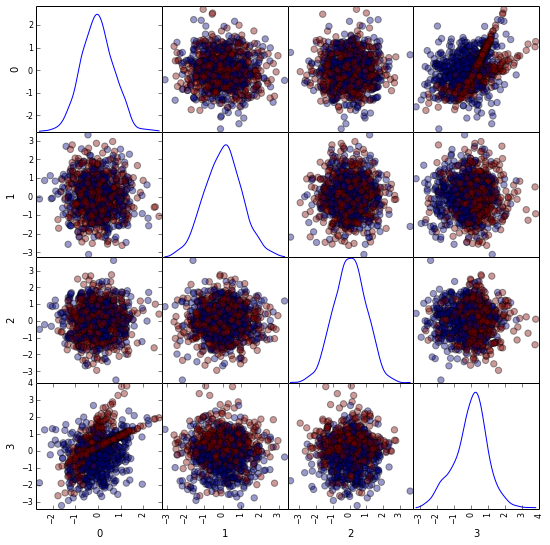

In [19]:
X, y = sklearn.datasets.make_classification(
    n_samples=10000, n_features=4, n_redundant=0, n_informative=2, 
    n_clusters_per_class=2, hypercube=False, random_state=0
)

print "shape of X: ", X.shape
print "shape of y: ", y.shape

# Split into train and test
X, Xt, y, yt = sklearn.cross_validation.train_test_split(X, y)

# Visualize sample of the data
ind = np.random.permutation(X.shape[0])[:1000]
df = pd.DataFrame(X[ind])
_ = pd.scatter_matrix(df, figsize=(9, 9), diagonal='kde', marker='o', s=40, alpha=.4, c=y[ind])

In [3]:
sklearn.datasets.make_classification?
pd.scatter_matrix?

**sklearn.datasets.make_classification?**

```
Signature: sklearn.datasets.make_classification(n_samples=100, n_features=20, n_informative=2, n_redundant=2, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
Docstring:
Generate a random n-class classification problem.

This initially creates clusters of points normally distributed (std=1)
about vertices of a `2 * class_sep`-sided hypercube, and assigns an equal
number of clusters to each class. It introduces interdependence between
these features and adds various types of further noise to the data.

Prior to shuffling, `X` stacks a number of these primary "informative"
features, "redundant" linear combinations of these, "repeated" duplicates
of sampled features, and arbitrary noise for and remaining features.

Read more in the :ref:`User Guide <sample_generators>`.
```

**pd.scatter_matrix?**

```
Signature: pd.scatter_matrix(frame, alpha=0.5, figsize=None, ax=None, grid=False, diagonal='hist', marker='.', density_kwds=None, hist_kwds=None, range_padding=0.05, **kwds)
Docstring:
Draw a matrix of scatter plots.

Parameters
----------
frame : DataFrame
alpha : float, optional
    amount of transparency applied
figsize : (float,float), optional
    a tuple (width, height) in inches
ax : Matplotlib axis object, optional
grid : bool, optional
    setting this to True will show the grid
diagonal : {'hist', 'kde'}
    pick between 'kde' and 'hist' for
    either Kernel Density Estimation or Histogram
    plot in the diagonal
marker : str, optional
    Matplotlib marker type, default '.'
hist_kwds : other plotting keyword arguments
    To be passed to hist function
density_kwds : other plotting keyword arguments
    To be passed to kernel density estimate plot
range_padding : float, optional
    relative extension of axis range in x and y
    with respect to (x_max - x_min) or (y_max - y_min),
    default 0.05
kwds : other plotting keyword arguments
    To be passed to scatter function

Examples
--------
>>> df = DataFrame(np.random.randn(1000, 4), columns=['A','B','C','D'])
>>> scatter_matrix(df, alpha=0.2)
File:      /usr/local/lib/python2.7/dist-packages/pandas/tools/plotting.py
Type:      function
```

Learn and evaluate scikit-learn's logistic regression with stochastic gradient descent (SGD) training. Time and check the classifier's accuracy.

In [4]:
%%timeit
# Train and test the scikit-learn SGD logistic regression.
clf = sklearn.linear_model.SGDClassifier(
    loss='log', n_iter=1000,  penalty='l2', alpha=1e-3, class_weight='auto')
clf.fit(X, y)
yt_pred = clf.predict(Xt)
print('Accuracy: {:.3f}'.format(sklearn.metrics.accuracy_score(yt, yt_pred)))
print "done"

/usr/local/lib/python2.7/dist-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Accuracy: 0.768
done


/usr/local/lib/python2.7/dist-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Accuracy: 0.767
done


/usr/local/lib/python2.7/dist-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Accuracy: 0.767
done


/usr/local/lib/python2.7/dist-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


Accuracy: 0.768
done
1 loop, best of 3: 521 ms per loop


在 cell-mode 里，`%%timeit` 会统计整个 cell 的运行时间。看帮助：`timeit?`

Save the dataset to HDF5 for loading in Caffe.

这个牛逼啊！scikit 和 caffe 结合一起玩！

In [5]:
# Write out the data to HDF5 files in a temp directory.
# This file is assumed to be caffe_root/examples/hdf5_classification.ipynb
print os.path.realpath(os.getcwd())

dirname = os.path.abspath('./examples/hdf5_classification/data')
print "dirname is", dirname
if not os.path.exists(dirname):
    os.makedirs(dirname)

train_filename = os.path.join(dirname, 'train.h5')
test_filename = os.path.join(dirname, 'test.h5')

# HDF5DataLayer source should be a file containing a list of HDF5 filenames.
# To show this off, we'll list the same data file twice.
with h5py.File(train_filename, 'w') as f:
    f['data'] = X
    f['label'] = y.astype(np.float32)
with open(os.path.join(dirname, 'train.txt'), 'w') as f:
    f.write(train_filename + '\n')
    f.write(train_filename + '\n')
    
# HDF5 is pretty efficient, but can be further compressed.
comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}
with h5py.File(test_filename, 'w') as f:
    f.create_dataset('data', data=Xt, **comp_kwargs)
    f.create_dataset('label', data=yt.astype(np.float32), **comp_kwargs)
with open(os.path.join(dirname, 'test.txt'), 'w') as f:
    f.write(test_filename + '\n') 

/home/tzx/dev/caffe-rc3
dirname is /home/tzx/dev/caffe-rc3/examples/hdf5_classification/data


In [20]:
!ls examples/hdf5_classification/data -alh

print "\ncat test.txt"
!cat examples/hdf5_classification/data/test.txt

print "\ncat train.txt"
!cat examples/hdf5_classification/data/train.txt

# 可以看到，这两个 txt 文件，只是指定了 h5 的位置。

total 376K
drwxrwxr-x 2 tzx tzx 4.0K  6月 21 14:29 .
drwxrwxr-x 3 tzx tzx 4.0K  6月 15 17:45 ..
-rw-rw-r-- 1 tzx tzx  83K  6月 21 14:29 test.h5
-rw-rw-r-- 1 tzx tzx   66  6月 21 14:29 test.txt
-rw-rw-r-- 1 tzx tzx 266K  6月 21 14:29 train.h5
-rw-rw-r-- 1 tzx tzx 1.7K  6月 21 14:29 train_iter_10000.caffemodel
-rw-rw-r-- 1 tzx tzx 1.3K  6月 21 14:29 train_iter_10000.solverstate
-rw-rw-r-- 1 tzx tzx  134  6月 21 14:29 train.txt

cat test.txt
/home/tzx/dev/caffe-rc3/examples/hdf5_classification/data/test.h5

cat train.txt
/home/tzx/dev/caffe-rc3/examples/hdf5_classification/data/train.h5
/home/tzx/dev/caffe-rc3/examples/hdf5_classification/data/train.h5


Let's define logistic regression in Caffe through Python net specification.
This is a quick and natural way to define nets that sidesteps manually editing the protobuf model.

然后用 caffe 来。

In [7]:
from caffe import layers as L
from caffe import params as P

def logreg(hdf5, batch_size):
    # 跟之前一样，先 net spec，然后
    # 把在这个类似 key-value pair 的 net spec 上定义网络的每一层
    # logistic regression: data, matrix multiplication, and 2-class softmax loss
    n = caffe.NetSpec()
    # data，label
    n.data, n.label = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=2)
    # 内积层，这个 xavier 后面有链接补充说明。
    n.ip1 = L.InnerProduct(n.data, num_output=2, weight_filler=dict(type='xavier'))
    n.accuracy = L.Accuracy(n.ip1, n.label)
    n.loss = L.SoftmaxWithLoss(n.ip1, n.label)
    return n.to_proto()
    
with open('examples/hdf5_classification/logreg_auto_train.prototxt', 'w') as f:
    f.write(str(logreg('examples/hdf5_classification/data/train.txt', 10)))
    
with open('examples/hdf5_classification/logreg_auto_test.prototxt', 'w') as f:
    f.write(str(logreg('examples/hdf5_classification/data/test.txt', 10)))

In [8]:
print "\n\t\texamples/hdf5_classification/logreg_auto_train.prototxt"
!cat examples/hdf5_classification/logreg_auto_train.prototxt
print "\n\t\texamples/hdf5_classification/logreg_auto_test.prototxt"
!cat examples/hdf5_classification/logreg_auto_test.prototxt
print "\n\t\texamples/hdf5_classification/solver.prototxt"
!cat examples/hdf5_classification/solver.prototxt


		examples/hdf5_classification/logreg_auto_train.prototxt
layer {
  name: "data"
  type: "HDF5Data"
  top: "data"
  top: "label"
  hdf5_data_param {
    source: "examples/hdf5_classification/data/train.txt"
    batch_size: 10
  }
}
layer {
  name: "ip1"
  type: "InnerProduct"
  bottom: "data"
  top: "ip1"
  inner_product_param {
    num_output: 2
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "accuracy"
  type: "Accuracy"
  bottom: "ip1"
  bottom: "label"
  top: "accuracy"
}
layer {
  name: "loss"
  type: "SoftmaxWithLoss"
  bottom: "ip1"
  bottom: "label"
  top: "loss"
}

		examples/hdf5_classification/logreg_auto_test.prototxt
layer {
  name: "data"
  type: "HDF5Data"
  top: "data"
  top: "label"
  hdf5_data_param {
    source: "examples/hdf5_classification/data/test.txt"
    batch_size: 10
  }
}
layer {
  name: "ip1"
  type: "InnerProduct"
  bottom: "data"
  top: "ip1"
  inner_product_param {
    num_output: 2
    weight_filler {
      type: "xavier"
    }
  }

Time to learn and evaluate our Caffeinated logistic regression in Python.

这里有 xavier 的说明：

-   [What does "xavier" mean? · Issue #1537 · BVLC/caffe](https://github.com/BVLC/caffe/issues/1537)
-   [andy's blog — An Explanation of Xavier Initialization](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization)

In [9]:
%%timeit
caffe.set_mode_cpu()
solver = caffe.get_solver('examples/hdf5_classification/solver.prototxt')
solver.solve()

accuracy = 0
batch_size = solver.test_nets[0].blobs['data'].num
test_iters = int(len(Xt) / batch_size)
for i in range(test_iters):
    solver.test_nets[0].forward()
    accuracy += solver.test_nets[0].blobs['accuracy'].data
accuracy /= test_iters

print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.760
Accuracy: 0.760
Accuracy: 0.760
Accuracy: 0.760
1 loop, best of 3: 131 ms per loop


In [21]:
!cat examples/hdf5_classification/solver.prototxt

train_net: "examples/hdf5_classification/logreg_auto_train.prototxt"
test_net: "examples/hdf5_classification/logreg_auto_test.prototxt"
test_iter: 250
test_interval: 1000
base_lr: 0.01
lr_policy: "step"
gamma: 0.1
stepsize: 5000
display: 1000
max_iter: 10000
momentum: 0.9
weight_decay: 0.0005
snapshot: 10000
snapshot_prefix: "examples/hdf5_classification/data/train"
solver_mode: CPU


Do the same through the command line interface for detailed output on the model and solving.

In [22]:
%%timeit
print os.path.realpath(os.getcwd())
!./build/tools/caffe train -solver examples/hdf5_classification/solver.prototxt

/home/tzx/dev/caffe-rc3
I0621 14:33:46.982236  6051 caffe.cpp:178] Use CPU.
I0621 14:33:47.247102  6051 solver.cpp:48] Initializing solver from parameters: 
train_net: "examples/hdf5_classification/logreg_auto_train.prototxt"
test_net: "examples/hdf5_classification/logreg_auto_test.prototxt"
test_iter: 250
test_interval: 1000
base_lr: 0.01
display: 1000
max_iter: 10000
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 5000
snapshot: 10000
snapshot_prefix: "examples/hdf5_classification/data/train"
solver_mode: CPU
I0621 14:33:47.247310  6051 solver.cpp:81] Creating training net from train_net file: examples/hdf5_classification/logreg_auto_train.prototxt
I0621 14:33:47.247520  6051 net.cpp:49] Initializing net from parameters: 
state {
  phase: TRAIN
}
layer {
  name: "data"
  type: "HDF5Data"
  top: "data"
  top: "label"
  hdf5_data_param {
    source: "examples/hdf5_classification/data/train.txt"
    batch_size: 10
  }
}
layer {
  name: "ip1"
  type: "InnerProdu

If you look at output or the `logreg_auto_train.prototxt`, you'll see that the model is simple logistic regression.
We can make it a little more advanced by introducing a non-linearity between weights that take the input and weights that give the output -- now we have a two-layer network.
That network is given in `nonlinear_auto_train.prototxt`, and that's the only change made in `nonlinear_solver.prototxt` which we will now use.

The final accuracy of the new network should be higher than logistic regression!

In [23]:
from caffe import layers as L
from caffe import params as P

def nonlinear_net(hdf5, batch_size):
    # one small nonlinearity, one leap for model kind
    n = caffe.NetSpec()
    n.data, n.label = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=2)
    # define a hidden layer of dimension 40
    n.ip1 = L.InnerProduct(n.data, num_output=40, weight_filler=dict(type='xavier'))
    # transform the output through the ReLU (rectified linear) non-linearity
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    # score the (now non-linear) features
    n.ip2 = L.InnerProduct(n.ip1, num_output=2, weight_filler=dict(type='xavier'))
    # same accuracy and loss as before
    n.accuracy = L.Accuracy(n.ip2, n.label)
    n.loss = L.SoftmaxWithLoss(n.ip2, n.label)
    return n.to_proto()
    
with open('examples/hdf5_classification/nonlinear_auto_train.prototxt', 'w') as f:
    f.write(str(nonlinear_net('examples/hdf5_classification/data/train.txt', 10)))
    
with open('examples/hdf5_classification/nonlinear_auto_test.prototxt', 'w') as f:
    f.write(str(nonlinear_net('examples/hdf5_classification/data/test.txt', 10)))   

In [25]:
%%timeit
#caffe.set_mode_cpu()
caffe.set_mode_cpu()
solver = caffe.get_solver('examples/hdf5_classification/nonlinear_solver.prototxt')
solver.solve()

accuracy = 0
batch_size = solver.test_nets[0].blobs['data'].num
test_iters = int(len(Xt) / batch_size)
for i in range(test_iters):
    solver.test_nets[0].forward()
    accuracy += solver.test_nets[0].blobs['accuracy'].data
accuracy /= test_iters

print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.832
Accuracy: 0.832
Accuracy: 0.832
Accuracy: 0.830
1 loop, best of 3: 217 ms per loop


CPU: 1 loop, best of 3: 217 ms per loop
GPU: 1 loop, best of 3: 4.45 s per loop

Do the same through the command line interface for detailed output on the model and solving.

In [13]:
!./build/tools/caffe train -solver examples/hdf5_classification/nonlinear_solver.prototxt

I0621 14:29:35.583806  6016 caffe.cpp:178] Use CPU.
I0621 14:29:35.801146  6016 solver.cpp:48] Initializing solver from parameters: 
train_net: "examples/hdf5_classification/nonlinear_auto_train.prototxt"
test_net: "examples/hdf5_classification/nonlinear_auto_test.prototxt"
test_iter: 250
test_interval: 1000
base_lr: 0.01
display: 1000
max_iter: 10000
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 5000
snapshot: 10000
snapshot_prefix: "examples/hdf5_classification/data/train"
solver_mode: CPU
I0621 14:29:35.801311  6016 solver.cpp:81] Creating training net from train_net file: examples/hdf5_classification/nonlinear_auto_train.prototxt
I0621 14:29:35.801509  6016 net.cpp:49] Initializing net from parameters: 
state {
  phase: TRAIN
}
layer {
  name: "data"
  type: "HDF5Data"
  top: "data"
  top: "label"
  hdf5_data_param {
    source: "examples/hdf5_classification/data/train.txt"
    batch_size: 10
  }
}
layer {
  name: "ip1"
  type: "InnerProduct"
  bottom: "

In [14]:
# Clean up (comment this out if you want to examine the hdf5_classification/data directory).
# shutil.rmtree(dirname)